# YOLO training notebook
Environment: `yolo_train_venv`
Repo root: `~/pole_perception`
Dataset: `data/yolo_pole_dataset/dataset.yaml`

In [1]:
# kernel / env check
import sys, os
print("Python:", sys.executable)
print("CWD:", os.getcwd())

# optional: check torch and cuda availability
try:
    import torch
    print("torch:", torch.__version__, "cuda:", torch.cuda.is_available())
except Exception as e:
    print("torch not available:", e)

Python: /home/avosughi/pole_perception/yolo_train_venv/bin/python
CWD: /home/avosughi/pole_perception/notebooks
torch: 2.9.1+cu130 cuda: True


## Train model directly (will block until the training is over) 

In [ ]:
import os
os.chdir("/home/avosughi/pole_perception")
print("New CWD:", os.getcwd())

In [5]:
%%bash
yolo train \
  model=yolo11n.pt \
  data=data/yolo_pole_dataset/dataset.yaml \
  imgsz=512 \
  batch=4 \
  epochs=100 \
  mosaic=0 \
  auto_augment=0 \
  erasing=0

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.10.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 2070 with Max-Q Design, 8192MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=0, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/yolo_pole_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0, multi_scale=False, name=train4, nbs

bash: line 9: 76804 Killed                  yolo train model=yolo11n.pt data=data/yolo_pole_dataset/dataset.yaml imgsz=512 batch=4 epochs=100 mosaic=0 auto_augment=0 erasing=0


CalledProcessError: Command 'b'yolo train \\\n  model=yolo11n.pt \\\n  data=data/yolo_pole_dataset/dataset.yaml \\\n  imgsz=512 \\\n  batch=4 \\\n  epochs=100 \\\n  mosaic=0 \\\n  auto_augment=0 \\\n  erasing=0\n'' returned non-zero exit status 137.

## Show the last trainign image

In [7]:
from IPython.display import Image, display
import glob, os

# find latest runs directory (Ultralytics typically saves to runs/train/exp, exp2, ... )
runs = sorted(glob.glob('runs/detect/*'), key=os.path.getmtime, reverse=True)
if runs:
    last = runs[0]
    # example: show results.png or labels/ or weights
    possible = [os.path.join(last, 'results.png'), os.path.join(last, 'plots', 'confusion_matrix.png')]
    for p in possible:
        if os.path.exists(p):
            display(Image(filename=p))
            break
    else:
        print("No image found in", last, " — list files:", os.listdir(last)[:10])
else:
    print("No runs found yet in runs/train/")

No image found in runs/detect/train4  — list files: ['train_batch2.jpg', 'args.yaml', 'weights', 'train_batch0.jpg', 'train_batch1.jpg', 'results.csv', 'labels.jpg']


## Train on Background (recommended)
To run the training in background without blocking notebook

In [9]:
import subprocess, time, os

logfile = 'runs/train/train_background.log'
os.makedirs(os.path.dirname(logfile), exist_ok=True)

cmd = [
    "yolo", "train",
    "model=yolo11n.pt",
    "data=data/yolo_pole_dataset/dataset.yaml",
    "imgsz=512",
    "batch=4",
    "epochs=100",
    "mosaic=1",
    "auto_augment=2",
    "erasing=0.5"
]

# start the process; it will continue after cell finishes
with open(logfile, "wb") as out:
    p = subprocess.Popen(" ".join(cmd), shell=True, stdout=out, stderr=subprocess.STDOUT)

print("Started background training pid", p.pid, "logs ->", logfile)
# to check progress later, display tail:
!tail -n 50 runs/train/train_background.log

Started background training pid 140654 logs -> runs/train/train_background.log


## To use and validate the model after training


image 1/1 /home/avosughi/pole_perception/assets/test_image.jpg: 288x512 1 pole, 74.9ms
Speed: 8.1ms preprocess, 74.9ms inference, 8.4ms postprocess per image at shape (1, 3, 288, 512)


(np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5))

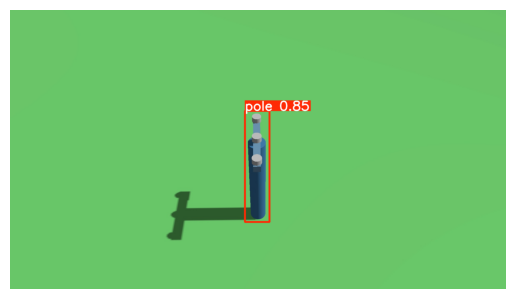

In [8]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

# Load model
model = YOLO("runs/detect/train3/weights/best.pt")

# Run inference
result = model("assets/test_image.jpg")[0]

# Show result
plt.imshow(result.plot())
plt.axis("off")